In [1]:
import numpy as np
import pandas as pd
np.random.seed(42)

In [2]:
import tensorflow as tf
tf.set_random_seed(42)
from keras.models import Model
from keras.layers import (Dense, Conv2D, BatchNormalization,
                          MaxPooling2D, Flatten, Dropout, Input)
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import SGD

Using TensorFlow backend.


In [3]:
from imutils import resize

In [4]:
from scipy.misc import imread, imresize

In [5]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [6]:
from keras.models import load_model

In [7]:
root = 'data2/'

In [8]:
import os
print(os.listdir(root))
from PIL import Image

['good_pose', 'phone_mobile']


In [9]:
# create a class to store global variables
class Configuration:
    def __init__(self):
        
        self.epochs = 10
        self.batch_size = 16
        
        self.maxwidth = 0
        self.maxheight = 0
        self.minwidth = 35000
        self.minheight = 35000
        
        self.imgcount = 0
        
        self.img_width_adjust = 1280
        self.img_height_adjust = 720
        self.img_channels = 3
        
        self.data_dir = root

In [10]:
config = Configuration()

### Data Exploration 

(720, 1280, 3)

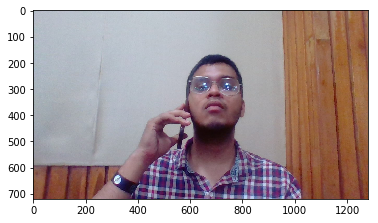

In [11]:
# load an example photo
img = mpimg.imread('data2/phone_mobile/WIN_20190331_01_48_07_Pro.jpg')
imgplot = plt.imshow(img)
img.shape

In [12]:
# Find the largest and smallest dimensions of all the pictures
def findPictureDims(path):
    config.imgcount=0
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".jpg"):
                config.imgcount+=1
                filename = os.path.join(subdir, file)
                
                image = Image.open(filename)
                width, height = image.size
                if width < config.minwidth:
                    config.minwidth = width
                if height < config.minheight:
                    config.minheight = height
                if width > config.maxheight:
                    config.maxwidth = width
                if height > config.maxheight:
                    config.maxheight = height
                
    return

In [13]:
# Count the number of files in each subdirectory
def listDirectoryCounts(path):
    d = []
    for root, dirs, files in os.walk(path, topdown=False):
        filecount = len(files)
        d.append((root, filecount))
        
    return d[:-1]

In [14]:
def SplitCat(df):
    
    for index, row in df.iterrows():
        directory = row['Category'].split('/')[1]
        df.at[index, 'Category'] = directory
    
    return df
    

In [15]:
# Get image count per category
dirCount = listDirectoryCounts(config.data_dir)
categoryInfo = pd.DataFrame(dirCount, columns=['Category', 'Count'])
SplitCat(categoryInfo)

,Category,Count
0,good_pose,621
1,phone_mobile,628


In [16]:
categoryInfo = categoryInfo.sort_values(by=['Count'])
categoryInfo

,Category,Count
0,good_pose,621
1,phone_mobile,628


In [17]:
# printing min-max image dim & image count
findPictureDims(config.data_dir)
print('min-width:', config.minwidth)
print('min-height:', config.minheight)
print('max-width:', config.maxwidth)
print('max-height:', config.maxheight)
print('Image Count:', config.imgcount)

min-width: 640
min-height: 480
max-width: 1280
max-height: 720
Image Count: 1249


In [18]:
config.img_height_adjust

720

In [19]:
REDUCE_PERCENT = 0.7

In [20]:
def adjust_dim(rp=REDUCE_PERCENT):
    '''
    rp : reduce percentage
    '''
    return (round(config.img_height_adjust - config.img_height_adjust*rp),
            round(config.img_width_adjust - config.img_width_adjust*rp),
            config.img_channels)

In [21]:
adjust_dim()

(216, 384, 3)

In [22]:
# model Definition
def build_model(input_shape, classes):
    
    # Input
    inputs = Input(shape=input_shape,
                  name='input')
    
    # Convolution-Maxpool Block 1
    conv1 = Conv2D(128, kernel_size=(3,3),
                   activation='relu', name='conv_1')(inputs)
    pool1 = MaxPooling2D(name='pool_1')(conv1)
    
    # Convolution-Maxpool Block 2
    conv2 = Conv2D(64, kernel_size=(3,3),
                   activation='relu', name='conv_2')(pool1)
    pool2 = MaxPooling2D(name='pool_2')(conv2)
    
    # Convolution-Maxpool Block 3
    conv3 = Conv2D(32, kernel_size=(3,3),
                   activation='relu', name='conv_3')(pool2)
    pool3 = MaxPooling2D(name='pool_3')(conv3)
    
    # Convolution-Maxpool Block 4
    conv4 = Conv2D(16, kernel_size=(3,3),
                   activation='relu', name='conv_4')(pool3)
    pool4 = MaxPooling2D(name='pool_4')(conv4)
    
    # Flatten
    flatten = Flatten()(pool4)
    
    # Dense Layer
    fc1 = Dense(1024, activation='relu', name='fc_1')(flatten)
    
    # output Layer
    output = Dense(classes, activation='softmax', name='softmax')(fc1)
    
    # Finalize and Compile
    model = Model(inputs=inputs, outputs= output)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                 metrics=['accuracy'])
    return model
    

In [23]:
def setup_data(train_data_dir, val_data_dir,
               img_width=config.img_width_adjust,
               img_height=config.img_height_adjust,
              batch_size=config.batch_size):
    
    # augmentation parameters
    train_datagen = ImageDataGenerator(
                                rescale=1./255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.3,
                                horizontal_flip=True,
                                fill_mode='nearest',
                                validation_split=0.2)
    
    # reading from directory:
    # train generator
    train_generator = train_datagen.flow_from_directory(
                                train_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                subset='training')
    
    # valid generator
    validation_generator = train_datagen.flow_from_directory(
                                train_data_dir,
                                target_size=(img_width, img_height),
                                batch_size=batch_size,
                                class_mode='categorical',
                                subset='validation')
    
    return train_generator, validation_generator

In [24]:
def fit_model(model, train_generator, val_generator,
              batch_size, epochs):
    
    model.fit_generator(
            train_generator,
            steps_per_epoch = train_generator.samples // batch_size,
            epochs = epochs,
            validation_data = val_generator,
            validation_steps = val_generator.samples // batch_size,
            verbose = 1)
    return model

In [25]:
def eval_model(model, val_generator, batch_size):
    
    scores = model.evaluate_generator(
            val_generator,
            steps=val_generator.samples // batch_size)
    
    print("Loss: "+str(scores[0]) + "\n Accuracy: "+str(scores[1]))

In [26]:
# Loading data for train-valid (80-20)
train_generator, val_generator = setup_data(config.data_dir,
                                            config.data_dir,
                                            img_width=adjust_dim(REDUCE_PERCENT)[0],
                                            img_height=adjust_dim(REDUCE_PERCENT)[1])

Found 1000 images belonging to 2 classes.
Found 249 images belonging to 2 classes.


In [27]:
train_generator.class_indices

{'good_pose': 0, 'phone_mobile': 1}

In [28]:
no_classes = len(set(train_generator.classes))

In [29]:
# Bulding the model
model = build_model(adjust_dim(REDUCE_PERCENT), no_classes)

In [30]:
# model summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 216, 384, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 214, 382, 128)     3584      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 107, 191, 128)     0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 105, 189, 64)      73792     
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 52, 94, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 50, 92, 32)        18464     
_________________________________________________________________
pool_3 (MaxPooling2D)        (None, 25, 46, 32)        0         
__________

In [33]:
model.targets

[<tf.Tensor 'softmax_target:0' shape=(?, ?) dtype=float32>]

In [42]:
# fitting the model
model = fit_model(model, train_generator, val_generator,
                 batch_size = config.batch_size, epochs=15)

Epoch 1/15
62/62 [==============================] - 38s 620ms/step - loss: 0.7019 - acc: 0.5040 - val_loss: 0.6876 - val_acc: 0.5020
Epoch 2/15
62/62 [==============================] - 39s 623ms/step - loss: 0.6907 - acc: 0.5635 - val_loss: 0.6815 - val_acc: 0.6145
Epoch 3/15
62/62 [==============================] - 39s 637ms/step - loss: 0.6788 - acc: 0.6169 - val_loss: 0.5609 - val_acc: 0.6908
Epoch 4/15
62/62 [==============================] - 41s 660ms/step - loss: 0.6463 - acc: 0.6572 - val_loss: 0.6325 - val_acc: 0.7470
Epoch 5/15
62/62 [==============================] - 40s 649ms/step - loss: 0.6156 - acc: 0.6683 - val_loss: 0.5562 - val_acc: 0.8112
Epoch 6/15
62/62 [==============================] - 39s 626ms/step - loss: 0.5663 - acc: 0.6976 - val_loss: 0.5456 - val_acc: 0.7751
Epoch 7/15
62/62 [==============================] - 38s 615ms/step - loss: 0.5509 - acc: 0.7218 - val_loss: 0.7140 - val_acc: 0.5823
Epoch 8/15
62/62 [==============================] - 38s 610ms/step - 

In [43]:
model.save('distracted_live_model_pose_phone_002.hdf5')

In [208]:
test_model = load_model('distracted_live_model_bin_001.hdf5')

In [120]:
test_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 216, 384, 3)       0         
_________________________________________________________________
conv_1 (Conv2D)              (None, 214, 382, 128)     3584      
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 107, 191, 128)     0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 105, 189, 64)      73792     
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 52, 94, 64)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 50, 92, 32)        18464     
_________________________________________________________________
pool_3 (MaxPooling2D)        (None, 25, 46, 32)        0         
__________

In [121]:
def get_test_data_path(path=config.data_dir,
                       target_size=adjust_dim(REDUCE_PERCENT)):
    
    classes = os.listdir(path)
    random_file_img = []
    random_file_label = []
    for c in classes:
        c_files = os.listdir(os.path.join(path, c))
        
        file_path = os.path.join(path, c, c_files[np.random.randint(len(c_files))])
        
        X_img = imread(file_path)
        
        X_img = imresize(X_img, target_size)
        
        random_file_img.append(X_img)
        random_file_label.append(c)
        
    
    return (np.array(random_file_img), np.array(random_file_label))

In [122]:
test_imgs, test_labels = get_test_data_path()

D:\anaconda\envs\deep-work\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if sys.path[0] == '':
D:\anaconda\envs\deep-work\lib\site-packages\ipykernel_launcher.py:14: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  


In [123]:
test_imgs.shape

(4, 216, 384, 3)

In [129]:
class_dict = train_generator.class_indices

In [132]:
def rev_dict(class_dict):
    class_dict_rev = {}
    for k in class_dict.keys():
        class_dict_rev[class_dict[k]] = k
    return class_dict_rev

In [149]:
class_dict_rev = rev_dict(class_dict=class_dict)

In [133]:
class_dict

{'good_pose': 0, 'look_back': 1, 'phone_call': 2, 'text_mobile': 3}

In [209]:
class_dict_rev

{0: 'good_pose', 1: 'look_back', 2: 'phone_call', 3: 'text_mobile'}

In [134]:
def labels_to_encode(labels, class_dict):

    encoded = []
    labels = np.array(labels).reshape(-1, 1)
    
    for lbl in labels:
        encoded.append(class_dict[lbl[0]])

    return np.array(encoded)

In [135]:
test_encoded_labels = labels_to_encode(test_labels, class_dict)
test_encoded_labels

array([0, 1, 2, 3])

In [136]:
pred_labels = np.argmax(test_model.predict(test_imgs), axis=1)
pred_labels

array([0, 1, 3, 3], dtype=int64)

In [198]:
def test_images(test_imgs=test_imgs, test_labels=test_labels, test_idx=0):
    
    test_imgs_reshaped = test_imgs[test_idx].reshape(reshape_dim)
    
    pred_lbl = np.argmax(test_model.predict(test_imgs_reshaped), axis=1)
    print(test_imgs[test_idx].shape)
    
    plt.imshow(test_imgs[test_idx].reshape(adjust_dim()))
    print(test_labels)
    plt.title('GT: ' + str(test_labels[0]) + ' | ' +
             'Pred: '+
             str(pred_lbl[0]))

In [195]:
adjust_dim()

(216, 384, 3)

In [142]:
reshape_dim = (-1, 216, 384, 3)

In [144]:
test_imgs[0].reshape(reshape_dim).shape

(1, 216, 384, 3)

In [146]:
test_pred = test_model.predict(test_imgs[0].reshape(reshape_dim))

In [147]:
test_pred

array([[1., 0., 0., 0.]], dtype=float32)

In [151]:
class_dict_rev[test_pred.argmax()]

'good_pose'

In [155]:
class_dict_rev

{0: 'good_pose', 1: 'look_back', 2: 'phone_call', 3: 'text_mobile'}

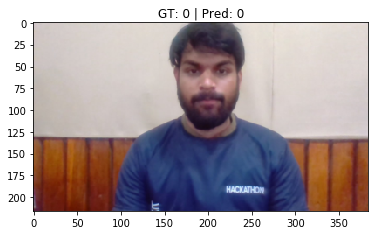

In [152]:
test_images(test_idx=0)

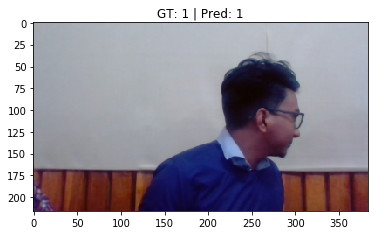

In [153]:
test_images(test_idx=1)

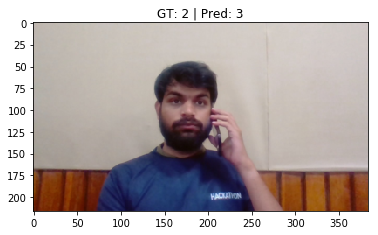

In [154]:
test_images(test_idx=2)

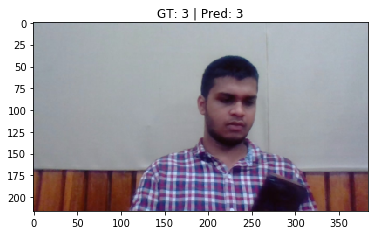

In [156]:
test_images(test_idx=3)

In [158]:
test_rand_file = 'data/look_back/look_back211.jpg'

In [166]:
class_dict

{'good_pose': 0, 'look_back': 1, 'phone_call': 2, 'text_mobile': 3}

In [171]:
rand_test_img_path.split('/')

['data', 'look_back', 'look_back12.jpg']

In [201]:
class_dict

{'good_pose': 0, 'look_back': 1, 'phone_call': 2, 'text_mobile': 3}

D:\anaconda\envs\deep-work\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  """


(1, 216, 384, 3)
[2]


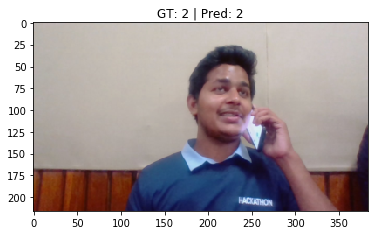

In [205]:
# load an example photo
rand_test_img_path = 'data/phone_call/phone_call039.jpg'
label = class_dict[rand_test_img_path.split('/')[1]]
rand_test_img = mpimg.imread(rand_test_img_path)
rand_test_img = imresize(rand_test_img, adjust_dim())
rand_test_img =  rand_test_img.reshape(reshape_dim)
test_images([rand_test_img], [label])